# Face Feature Analysis (FFA)
Facial Geometric Indicator Calculation(FGI)

In [2]:
import json
import glob
import os
import pandas as pd
import numpy as np
from facial_geometric_indicators import *

import cv2
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
all_ldmk_data = {}
all_images = {}
NW_id = []
NQ_id = []

for file_path in glob.glob(f'extracted/updated_landmarks/*.json'):
    file_name = os.path.basename(file_path)
    key1 = "-".join(file_name.split("-")[:2])
    key2 = file_name.split("-")[-1].split("_")[1]
    key = key1 + "-" + key2
    dyn = file_name.split("-")[3].split("_")
    if "NorthernWei" in dyn or "EasternWei" in dyn or "WesternWei" in dyn:
        NW_id.append(key)
    else:
        NQ_id.append(key)
    
    with open(file_path, 'r') as json_file:
        all_ldmk_data[key] = json.load(json_file)

for file_path in glob.glob(f'extracted/orthogonalized/*.png'):
    file_name = os.path.basename(file_path)
    key1 = "-".join(file_name.split("-")[:2])
    key2 = file_name.split("-")[-1].split("_")[1]
    key = key1 + "-" + key2
    all_images[key] = "extracted/orthogonalized/"+file_name


In [4]:
def index_generator(keys):
    while True:
        for key in keys:
            yield key

image_keys = sorted(all_ldmk_data.keys())
image_index_gen = index_generator(image_keys)

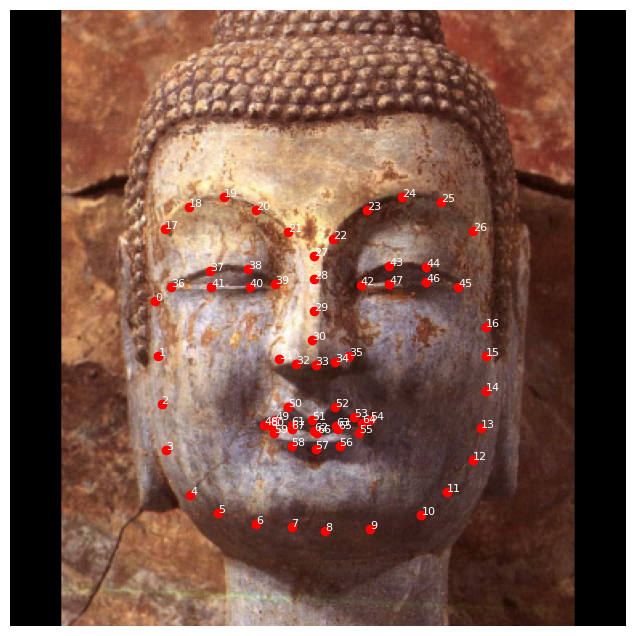

In [10]:
# idx = next(image_index_gen)
# print(idx)
idx = '36-36-0'
img_path = all_images[idx]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(image)

landmarks = all_ldmk_data[idx]
for n in range(0, len(landmarks)):
        x = landmarks[n][0]
        y = landmarks[n][1]
        ax.scatter([x], [y], c='red')
        ax.text(x, y, str(n), color='white', fontsize=8)

plt.axis('off') 
plt.show()

In [6]:
metadata = pd.read_csv('metadata.csv')
metadata.head()

,id,parent_id,category,period,head_body,head,body,head_body_en,TheBuddha(Sidhartha),Bodhisattva,Northern_Wei,Northern_Qi,Sui,Tang,period2,types
0,88,88,佛,北齐,['身'],False,True,-body,True,False,False,True,False,False,Northern_Qi,TheBuddha(Sidhartha)
1,66,66,佛,北齐,"['头', '身']",True,True,-head-body,True,False,False,True,False,False,Northern_Qi,TheBuddha(Sidhartha)
2,90,90,佛,北齐,['身'],False,True,-body,True,False,False,True,False,False,Northern_Qi,TheBuddha(Sidhartha)
3,28,28,菩萨,北魏_东魏,"['头', '身']",True,True,-head-body,False,True,True,False,False,False,Northern_Wei,Bodhisattva
4,190,190,菩萨,北齐,['头'],True,False,-head,False,True,False,True,False,False,Northern_Qi,Bodhisattva


In [34]:
def calculate_values_for_group(group, all_ldmk_data):
    values = []
    idx = []
    for file_name in group:
        landmarks = all_ldmk_data[file_name]
        fgi = FacialGeometricIndicators(landmarks)
        fgi.calculate_all()
        # fgi.calculate_fsa()
        values.append(fgi.get_fgi_values())
        idx.append(file_name)
    return values, idx


In [35]:
values_group_nq,idx_nq = calculate_values_for_group(NQ_id, all_ldmk_data)
values_group_nw,idx_nw= calculate_values_for_group(NW_id, all_ldmk_data)

In [36]:
from sklearn.preprocessing import MinMaxScaler

df_group_nw = pd.DataFrame(values_group_nw)
df_group_nw.index = idx_nw
df_group_nq = pd.DataFrame(values_group_nq)
df_group_nq.index = idx_nq

selected_col = ['LeftEyeWidth', 'RightEyeWidth', 'AvgEyeWidth', 'LeftEyeBreadth', 'RightEyeBreadth', 'AvgEyeBreadth', 'MouthWidth', 'UpperMouthThickness', 'LowerMouthThickness', 'SmileArc', 'JawLineAngle', 'JawCurvature']
scaler = MinMaxScaler()
df_group_nw[selected_col] = scaler.fit_transform(df_group_nw[selected_col])
df_group_nq[selected_col] = scaler.fit_transform(df_group_nq[selected_col])

## Visualization

In [38]:
def plot_histograms2(df1, df2):
    plt.figure(figsize=(15, 20))  
    
    keys = df1.columns
    n_keys = len(keys)
    n_rows = 5
    n_cols = 3

    for i, key in enumerate(keys):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        data1 = df1[key].dropna()  # Use dropna() to ignore NaN values
        ax.hist(data1, bins=10, alpha=0.5, color='blue', label=f'Northern Wei{key} mean: {data1.mean():.2f}', density=True)
        data2 = df2[key].dropna()  # Use dropna() to ignore NaN values
        ax.hist(data2, bins=10, alpha=0.5, color='orange', label=f'Norther Qi {key} mean: {data2.mean():.2f}', density=True)
        ax.set_title(f'{key}')
        ax.legend()

    # Turn off unused subplots
    for j in range(i + 1, n_rows * n_cols):
        plt.subplot(n_rows, n_cols, j + 1).axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

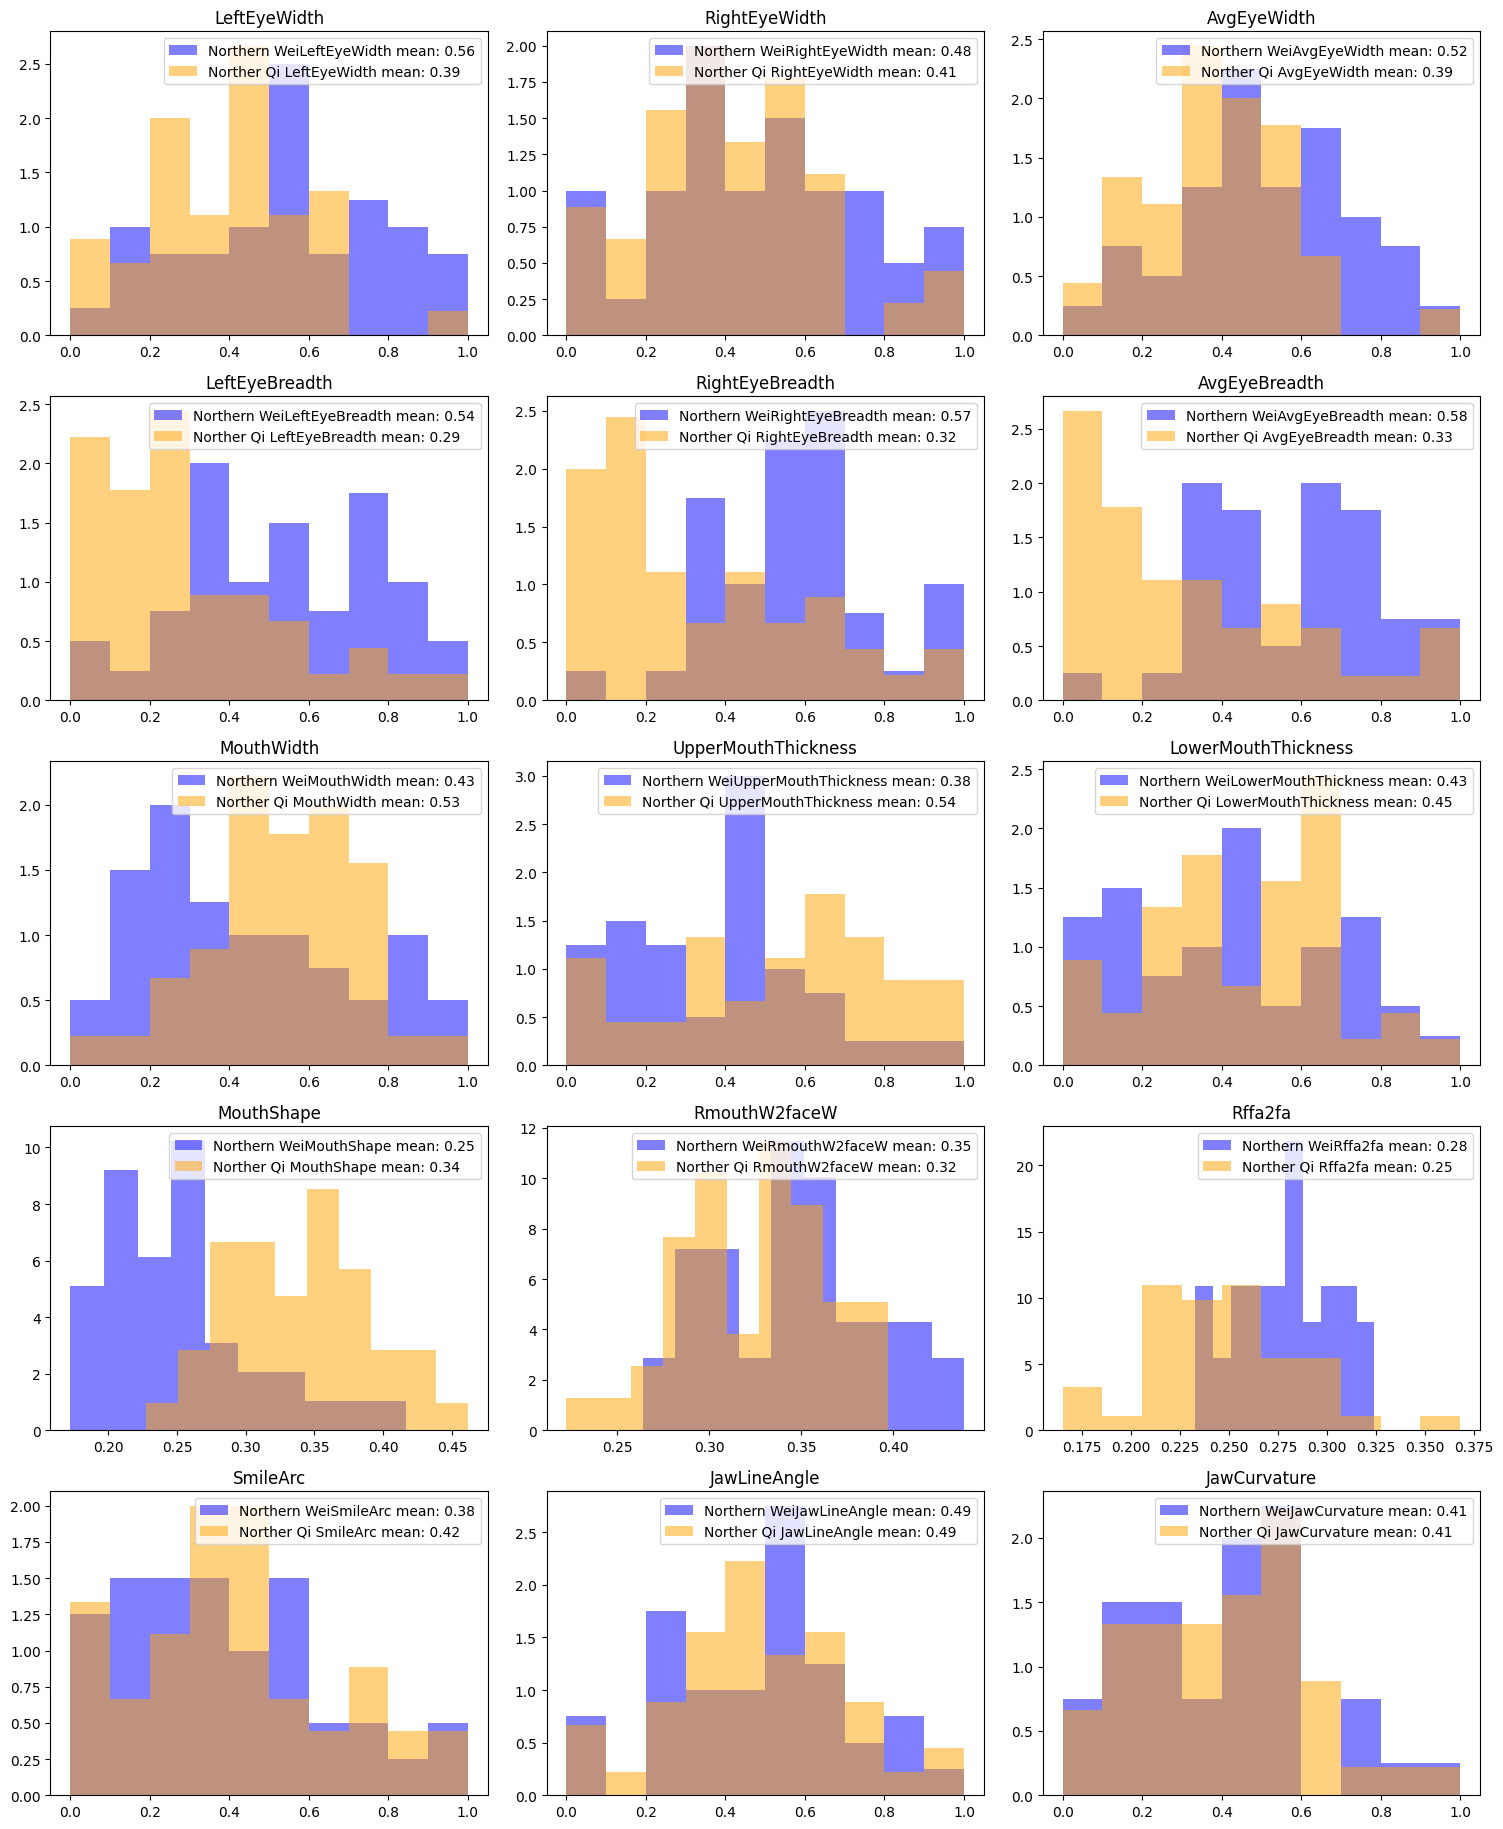

In [39]:
plot_histograms2(df_group_nw, df_group_nq)

## Hypothesis testing

In [40]:
from scipy import stats

In [49]:
keys = df_group_nw.columns
for k in keys:
    result = stats.ttest_ind(df_group_nw[k], df_group_nq[k])
    if result.pvalue <= 0.05:
        print(k + ": ", 'statistically different')
    else:
        print('Cannot reject the null hypothesis')

LeftEyeWidth:  statistically different
Cannot reject the null hypothesis
AvgEyeWidth:  statistically different
LeftEyeBreadth:  statistically different
RightEyeBreadth:  statistically different
AvgEyeBreadth:  statistically different
Cannot reject the null hypothesis
UpperMouthThickness:  statistically different
Cannot reject the null hypothesis
MouthShape:  statistically different
RmouthW2faceW:  statistically different
Rffa2fa:  statistically different
Cannot reject the null hypothesis
Cannot reject the null hypothesis
Cannot reject the null hypothesis
